In [1032]:
import pandas as pd
import numpy as np
import seaborn as sns
import mplcyberpunk
import matplotlib.pyplot as plt
plt.style.use('cyberpunk')

In [1033]:
data_train=pd.read_csv(r'C:\Users\Ashinth\Documents\courses\Kaggle\competetions\Titanic\train.csv')
data_test=pd.read_csv(r'C:\Users\Ashinth\Documents\courses\Kaggle\competetions\Titanic\test.csv')

In [1034]:
data_train.set_index('PassengerId')
data_test.set_index('PassengerId')
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Finding relations between variables

<AxesSubplot:xlabel='Parch', ylabel='count'>

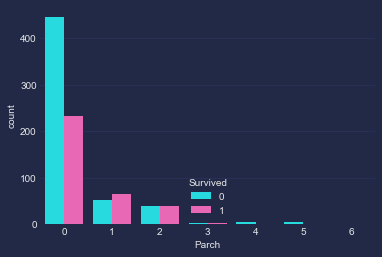

In [1035]:
sns.countplot(x=data_train.Parch,hue=data_train.Survived)

<AxesSubplot:xlabel='Pclass', ylabel='count'>

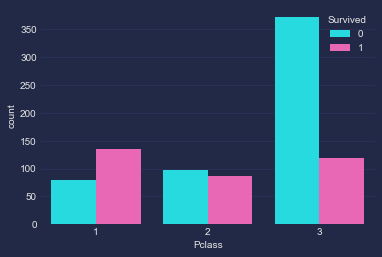

In [1036]:
sns.countplot(x=data_train.Pclass,hue=data_train.Survived)

<AxesSubplot:xlabel='Sex', ylabel='count'>

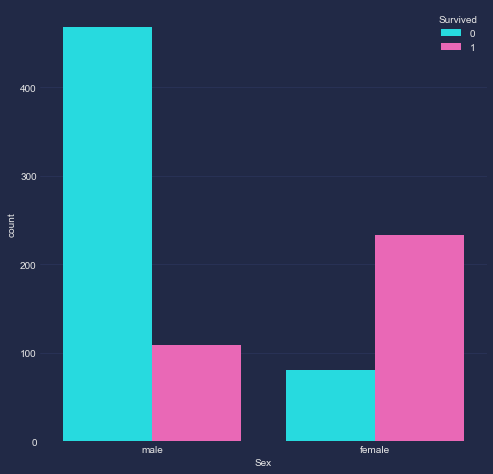

In [1037]:
plt.figure(figsize=(8,8))
sns.countplot(x=data_train.Sex,hue=data_train.Survived)

<AxesSubplot:xlabel='Age', ylabel='Count'>

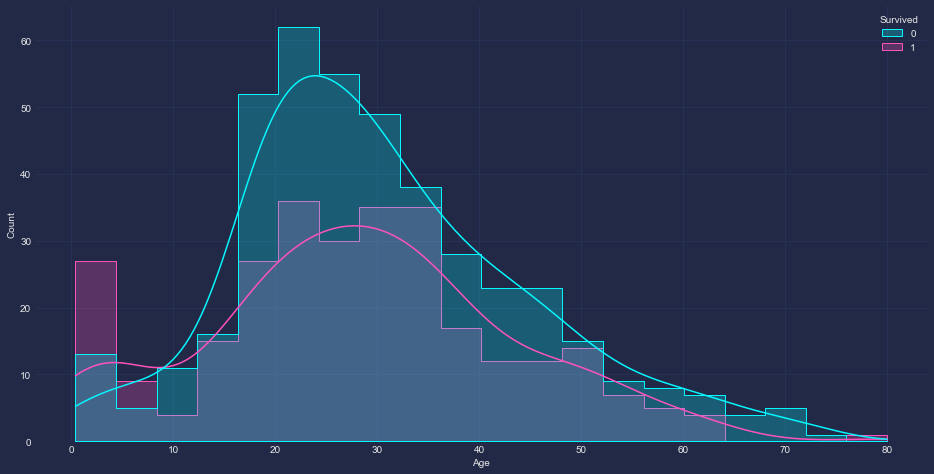

In [1038]:
plt.figure(figsize=(16,8))
sns.histplot(x=data_train.Age,hue=data_train.Survived,kde=True,element='step')

Pclass  Embarked
1       S           127
        C            85
        Q             2
2       S           164
        C            17
        Q             3
3       S           353
        Q            72
        C            66
Name: Embarked, dtype: int64


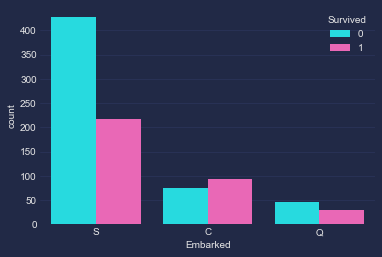

In [1039]:
sns.countplot(x=data_train.Embarked, hue= data_train.Survived)
print(data_train.groupby('Pclass').Embarked.value_counts())

This shows that most of the deaths are found to be in 3rd class, the least being the 1st class.  
The ratio of men to women deaths is also highly skewed.  
Children, irrespective of gender are more likely to survive.

### Preprocessing


In [1040]:
data_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [1041]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer

Selecting the features which will be fitted into the model

In [1042]:
# initially not including the cabin variable
cat_cols=[col for col in data_train.columns if data_train[col].dtype=='object' and data_train[col].nunique()<=10]
Y=data_train.pop('Survived')
num_cols=[col for col in data_train.columns if data_train[col].dtypes in ['float64','int64']]
X=data_train[cat_cols+num_cols]

Removing the index(PassengerId here)

In [1043]:
X_train,X_val,y_train,y_val= train_test_split(X,Y,test_size=0.2,random_state=0)
train_id=X_train.pop('PassengerId')
val_id=X_val.pop('PassengerId')
num_cols.remove('PassengerId')

Features containing null values

In [1044]:
# checking for columns containing null values, so as to select a strategy to impute them
z=[col for col in X.columns if X[col].isnull().any()]
z

['Embarked', 'Age']

Implementing a pipeline for imputing and encoding categorical variables  
Only imputing the numerical columns that contain null values  
Introducing a column transformer to fit the training data

In [1045]:
o_encod=OrdinalEncoder()
X_train[cat_cols]=o_encod.fit_transform(X_train[cat_cols])
X_val[cat_cols]=o_encod.transform(X_val[cat_cols])

In [1046]:
mms=MinMaxScaler()
scaled_cols= [col for col in num_cols if X_train[col].nunique() >= 30 and col not in ['Age']]
X_train[scaled_cols]=mms.fit_transform(X_train[scaled_cols])
X_val[scaled_cols]=mms.transform(X_val[scaled_cols])


In [1047]:
categorical= Pipeline(steps=[('imputer',SimpleImputer(strategy='constant'))])
numerical=SimpleImputer(strategy='mean')

preprocessing=ColumnTransformer(transformers=[('categoricals',categorical,cat_cols),('numericals',numerical,num_cols)])
X_train=pd.DataFrame(preprocessing.fit_transform(X_train))
X_val=preprocessing.transform(X_val)

In [1048]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier 

### Creating a model to evaluate the data  
As the training set has been preprocessed  
__The test set should also be preprocessed accordingly__

Random Forest Classifiers


In [1049]:
def forest_score(parameter):
    model=RandomForestClassifier(n_estimators=parameter,random_state=0)
    model.fit(X_train,y_train)
    predictions= model.predict(X_val)
    

    return predictions

In [1050]:
def forest_accuracy(data):
    model=RandomForestClassifier(n_estimators=parameter,random_state=0)
    model.fit(X_train,y_train)
    accuracy= model.predict(data)
    return accuracy

SVMs

In [1051]:
def SVM_score(parameter):
    model=SVC(C=parameter,random_state=0)
    model.fit(X_train,y_train)
    predictions= model.predict(X_val)
    

    return predictions

In [1052]:
def SVM_accuracy(data):
    model=SVC(C=parameter,random_state=0)
    model.fit(X_train,y_train)
    accuracy= model.predict(data)
    return accuracy

K-Nearest Neighbors

In [1053]:
def KNN_score(parameter):
    model=KNeighborsClassifier(n_neighbors=parameter)
    model.fit(X_train,y_train)
    predictions= model.predict(X_val)
    

    return predictions

In [1054]:
def KNN_accuracy(data):
    model=KNeighborsClassifier(n_neighbors=parameter)
    model.fit(X_train,y_train)
    accuracy= model.predict(data)
    return accuracy

Predicting the best model by tuning one of it's hyperparameter

In [1070]:
n_estimators=[2,4,8,12,15,20,25,30,40,90]   # for random forests and SVM's, since 40 is very large number of neighbors
#n_estimators=[2,3,4,5,8,12]                # for KNN 
accu=list()
for i in n_estimators:
    predictions=SVM_score(i)
    sc= accuracy_score(predictions,y_val)
    accu.append(sc)

ans=dict(zip(n_estimators,accu))
ans

{2: 0.7150837988826816,
 4: 0.8212290502793296,
 8: 0.8156424581005587,
 12: 0.8044692737430168,
 15: 0.8044692737430168,
 20: 0.8044692737430168,
 25: 0.8044692737430168,
 30: 0.8044692737430168,
 40: 0.8044692737430168,
 90: 0.8156424581005587}

Graph Showing the variation of the classification accuracy w.r.t the value of hyperparameter

Text(0, 0.5, 'Accuracy')

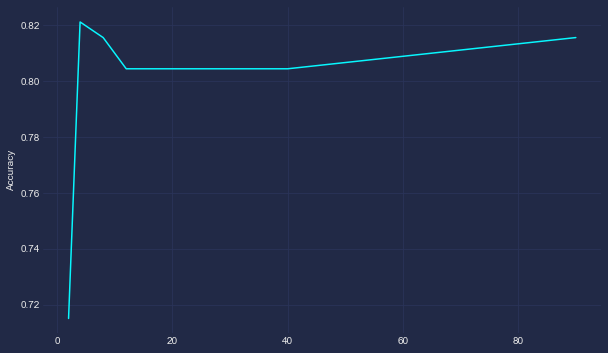

In [1071]:
plt.figure(figsize=(10,6))
sns.lineplot(x=n_estimators,y=accu)
plt.ylabel("Accuracy")

Finding the parameter that has given the maximum accuracy and use it for the modelling of test_data

In [1057]:
max_param=max(list(ans.values()))
max_param
val_list=list(ans.values())
key_list=list(ans.keys())
max_index=val_list.index(max_param)
parameter=key_list[max_index]

Final result for the validation data, in the form as asked by kaggle 

In [1058]:
result=pd.DataFrame(zip(val_id,predictions),columns=('PassengerId','Survived'),index=val_id)

### Preprocessing and evaluating test set.

In [1059]:
test_id=data_test.PassengerId
data_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [1060]:
data_test.drop(['PassengerId'],inplace=True,axis=1)

In [1061]:
X_test=data_test[cat_cols+num_cols]
X_test

,Sex,Embarked,Pclass,Age,SibSp,Parch,Fare
0,male,Q,3,34.5,0,0,7.8292
1,female,S,3,47.0,1,0,7.0000
2,male,Q,2,62.0,0,0,9.6875
3,male,S,3,27.0,0,0,8.6625
4,female,S,3,22.0,1,1,12.2875
...,...,...,...,...,...,...,...
413,male,S,3,NaN,0,0,8.0500
414,female,C,1,39.0,0,0,108.9000
415,male,S,3,38.5,0,0,7.2500
416,male,S,3,NaN,0,0,8.0500


In [1062]:
X_test[cat_cols]=o_encod.transform(X_test[cat_cols])
X_test[scaled_cols]=mms.transform(X_test[scaled_cols])
X_test=preprocessing.transform(X_test)

c:\Users\Ashinth\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
c:\Users\Ashinth\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Fitting the test data into the model.

In [1063]:
test_predictions=SVM_accuracy(X_test)

In [1064]:
test_result=pd.DataFrame(zip(test_id,test_predictions),columns=('PassengerId','Survived'),index=test_id)

Saving the result into the csv file

In [1065]:
test_result.to_csv('titanic.csv',index=False)